In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import tensorflow as tf
import keras

import random as rn

np.random.seed(42)
rn.seed(42)

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1,
                              inter_op_parallelism_threads=1)


from keras import backend as K

tf.set_random_seed(42)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

generate_data = False


x = np.load("data/x.npy")
y = np.load("data/y.npy")

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33, random_state=42)

Using TensorFlow backend.


In [2]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation, Flatten, Dropout
from keras.layers import Conv2D, MaxPooling2D, Flatten, BatchNormalization

In [3]:
# 2nd submission: test_size 0.3, batch_size=32, epochs=10, binary_crossentropy, adam
# model = Sequential()
# model.add(BatchNormalization(input_shape=(len(x_train[0]),)))
# model.add(Dense(300))
# model.add(Activation('relu'))
# model.add(Dropout(0.6))

# model.add(Dense(200))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.6))


# model.add(Dense(100))
# model.add(BatchNormalization())
# model.add(Activation('relu'))
# model.add(Dropout(0.3))



dropout = 0


model = Sequential()
model.add(BatchNormalization(input_shape=(len(x_train[0]),)))
model.add(Dense(300))
model.add(Activation('relu'))
model.add(Dropout(0.6))

model.add(Dense(200))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.6))


model.add(Dense(100))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.3))

In [4]:
model.add(Dense(1))
model.add(Activation('sigmoid'))

In [5]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
batch_normalization_1 (Batch (None, 382)               1528      
_________________________________________________________________
dense_1 (Dense)              (None, 300)               114900    
_________________________________________________________________
activation_1 (Activation)    (None, 300)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 300)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 200)               60200     
_________________________________________________________________
batch_normalization_2 (Batch (None, 200)               800       
_________________________________________________________________
activation_2 (Activation)    (None, 200)               0         
__________

In [6]:
from keras.callbacks import Callback

class Stat_Collector (Callback):
    def __init__(self, x_train, y_train, x_test, y_test):
        self.x_train = x_train
        self.y_train = y_train
        self.x_test = x_test
        self.y_test = y_test

        self.aucrocs_train = []
        self.aucrocs_val = []

    def on_epoch_end(self, batch, logs=None):
        # Make aucroc prediction for training data
        y_pred_train = self.model.predict(x_train)
        y_pred_train = y_pred_train.flatten()
        self.aucrocs_train.append(roc_auc_score(y_train, y_pred_train))
        
        
        # Make aucroc prediction for validation data
        y_pred_val = self.model.predict(x_test)
        y_pred_val = y_pred_val.flatten()
        self.aucrocs_val.append(roc_auc_score(y_test, y_pred_val))

In [7]:
stat_collect = Stat_Collector(x_train, y_train, x_test, y_test)

model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])

In [8]:
fit = model.fit(x_train, y_train, batch_size=32, nb_epoch=30, verbose=1, callbacks = [stat_collect])

/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:1: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """Entry point for launching an IPython kernel.


Epoch 1/30
43326/43326 [==============================] - 8s 175us/step - loss: 0.5433 - acc: 0.7378
Epoch 2/30
43326/43326 [==============================] - 5s 124us/step - loss: 0.4974 - acc: 0.7574
Epoch 3/30
43326/43326 [==============================] - 6s 136us/step - loss: 0.4901 - acc: 0.7652
Epoch 4/30
43326/43326 [==============================] - 6s 142us/step - loss: 0.4878 - acc: 0.7649
Epoch 5/30
43326/43326 [==============================] - 7s 155us/step - loss: 0.4852 - acc: 0.7675
Epoch 6/30
43326/43326 [==============================] - 6s 143us/step - loss: 0.4831 - acc: 0.7700
Epoch 7/30
43326/43326 [==============================] - 6s 128us/step - loss: 0.4821 - acc: 0.7688
Epoch 8/30
43326/43326 [==============================] - 6s 132us/step - loss: 0.4798 - acc: 0.7715
Epoch 9/30
43326/43326 [==============================] - 6s 135us/step - loss: 0.4782 - acc: 0.7731
Epoch 10/30
43326/43326 [==============================] - 6s 137us/step - loss: 0.4758 - a

In [9]:
def generate_csv(model, x_data, name):
    ids = [i for i, _ in enumerate(x_data)]
    ids = np.array(ids)
    
    predictions = model.predict(x_data).flatten()
    
    df = pd.DataFrame()
    df['id'] = ids
    df['target'] = predictions
    df.to_csv(name + ".csv", index=False)

#     print df.head()


generate_csv(model, x_test, "submissions/third_test")

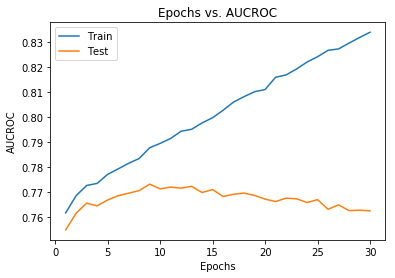

Test AUCROC maximized at epoch = 9 with AUCROC = 0.7730865674094878


In [10]:
import matplotlib.pyplot as plt

num_epoch = len(stat_collect.aucrocs_val)

# Plot training & validation accuracy values
plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_train, label="Train AUCROC")
plt.plot([x + 1 for x in range(num_epoch)], stat_collect.aucrocs_val, label="Test AUCROC")



plt.xlabel('Epochs')
plt.ylabel('AUCROC')
plt.title('Epochs vs. AUCROC')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig("hmm.png")
plt.show()
print('Test AUCROC maximized at epoch = {} with AUCROC = {}'.format(np.argmax(stat_collect.aucrocs_val) + 1, stat_collect.aucrocs_val[np.argmax(stat_collect.aucrocs_val)]))
